# Installing required libraries

In [1]:
!pip install geopy

# Importing required libraries

In [2]:
import time as t
import numpy as np
import math as m
import pandas as pd
import seaborn as sns
import csv
import geopy.distance
import matplotlib.pyplot as plt

# Read data from csv file to a list

In [3]:
def read_csv(file_name):
    data_list = list()
    with open(file_name, newline='') as csvfile:
        file_reader = csv.reader(csvfile, delimiter=',')
        next(csvfile)
        for line in file_reader:
            no = int(line[0])
            lat = float(line[1])
            lon = float(line[2])
            data = (no, lat, lon)
            data_list.append(data)
    return data_list

In [4]:
ppv = read_csv("ppv.csv")
people = read_csv("people.csv")

# Method 1: Vincenty’s Formulae
Assumes the Earth is an oblate spheroid

In [3]:
def vincenty_formula(person, ppv):
    person_pos = (person[1], person[2])
    ppv_pos = (ppv[1], ppv[2])
    dist = geopy.distance.geodesic(person_pos,ppv_pos).km
    return dist


def solution_method1(person, ppv_list):
    i = 0
    nearest_ppv = i
    min_dist = vincenty_formula(person, ppv_list[i])
    while i < len(ppv) - 1:
        i += 1
        new_dist = vincenty_formula(person, ppv_list[i])
        if new_dist < min_dist:
            min_dist = new_dist
            nearest_ppv = i
    
    return nearest_ppv, person[0], round(min_dist,2)


def assign_method1(people, ppv_list):
    results_list = list()
    i = 0
    while i < len(people):
        nearest_ppv, person, dist = solution_method1(people[i], ppv)
        result = (nearest_ppv, person, dist)
        results_list.append(result)
        i += 1
    
    return results_list


def method1_launcher():
    start = t.perf_counter()
    result = assign_method1(people,ppv)
    end = t.perf_counter()
    comp_time = end - start
    with open("method1solution.csv", "w") as file:
        data_writer = csv.writer(file)
        data_writer.writerow(["PPV", "Person", "Distance"])
        data_writer.writerows(result)
    return comp_time

method1_launcher()

# Method 2: Haversine Formula
Assumes the Earth is a sphere. Approximated radius R = 6371 km

In [4]:
R = 6371
def haversine_formula(person,ppv):
    lat1 = m.radians(person[1])
    lat2 = m.radians(ppv[1])
    lon1 = m.radians(person[2])
    lon2 = m.radians(ppv[2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (m.sin(dlat/2))**2 + m.cos(lat1) * m.cos(lat2) * (m.sin(dlon/2))**2
    c = 2 * m.atan2(m.sqrt(a), m.sqrt(1-a))
    d = R * c
    return d


def solution_method2(person, ppv_list):
    i = 0
    nearest_ppv = i
    min_dist = haversine_formula(person, ppv_list[i])
    while i < len(ppv) - 1:
        i += 1
        new_dist = haversine_formula(person, ppv_list[i])
        if new_dist < min_dist:
            min_dist = new_dist
            nearest_ppv = i    
    return nearest_ppv, person[0], round(min_dist,2)

def assign_method2(people, ppv_list):
    results_list = list()
    i = 0
    while i < len(people):
        nearest_ppv, person, dist = solution_method2(people[i], ppv_list)
        result = (nearest_ppv, person, dist)
        results_list.append(result)
        i += 1
    return results_list

def method2_launcher():
    start = t.perf_counter()
    result = assign_method2(people,ppv)
    end = t.perf_counter()
    comp_time = end - start
    with open("method2solution.csv", "w") as file:
        data_writer = csv.writer(file)
        data_writer.writerow(["PPV", "Person", "Distance"])
        data_writer.writerows(result)
    return comp_time

method2_launcher()

# Read data from csv file to a DataFrame

In [17]:
def read_csv2(file_name):
    data_list = pd.read_csv(file_name)
    return data_list

In [18]:
ppv_centers = read_csv2("ppv.csv")
people_list = read_csv2("people.csv")

# Method 3: Reading data to a DataFrame & using Numpy array to store results & using For-Loop

In [5]:
def solution_method3(ppv_centers, people_list):
    result_data = np.empty([0,3])
    for i in range(len(people_list)):
        min_dist = haversine_formula(list(people_list[["People", "Lat", "Lon"]].iloc[i]), list(ppv_centers[["PPV", "Lat", "Lon"]].iloc[0]))
        nearest_ppv = 0
        j = 1
        for j in range(len(ppv_centers)-1):
            dist = haversine_formula(people_list.iloc[i], ppv_centers.iloc[j])
            if dist < min_dist:
                min_dist = dist
                nearest_ppv = j
        result_data = np.append(result_data, np.array([[nearest_ppv, i, round(min_dist,2)]]), axis=0)
        
    return result_data

def method3_launcher():
    start = t.perf_counter()
    result_array = solution_method3(ppv_centers, people_list)
    end = t.perf_counter()
    comp_time = end - start
    result_df = pd.DataFrame(result_array, columns = ["PPV","Person","Distance"])
    result_df.to_csv("method3solution.csv", index=False)
    return comp_time

method3_launcher()

# Creating Shaded Density Plots

Reading execution time of the 3 methods and storing it to DataFrame

In [15]:
methods_exec_times = pd.read_csv("methods_runtime.csv")

Plotting the data on the chart

Text(0.5, 0, 'Execution Time (sec)')

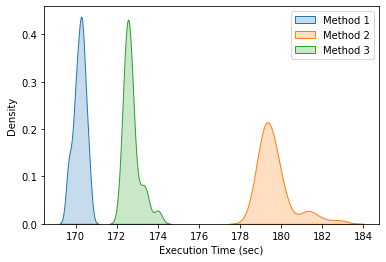

In [16]:
sns.kdeplot(data=methods_exec_times, shade=True)
plt.xlabel("Execution Time (sec)")

The computer used to test the methods was computer 1

For better visualization of data the results for method 2 is multiplied by 100 to decrease the difference between method 2 curve and method 1 & 3 curves 

From the shaded density plot, all the three methods produce a z-distribution curve. However, the results of method 1 is the closest to normal distribution while both results from method 2 and 3 are positively skewed. Execution time comparison shows that the fastest method is method 2 (as the actual time is time from the graph / 100) then followed by method 3 and the method 1 as the least efficient method 

Reading execution time of the 2 computers and storing it to DataFrame

In [39]:
computers_exec_times = pd.read_csv("computers_runtime.csv")

Plotting the data on the chart

Text(0.5, 0, 'Execution Time (sec)')

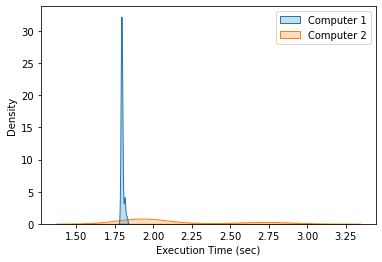

In [40]:
sns.kdeplot(data=computers_exec_times, shade=True)
plt.xlabel("Execution Time (sec)")

The two computers used had the following specifications:

Computer 1: 16GB RAM, AMD Ryzen 4800H 2.9 GHz, 1 TB SSD

Computer 2: 4GB RAM, Intel Core i5 8th Gen 1.6 GHz, 500 GB SSD

During the experiment both laptops were plugged in at 100% battery life

From the shaded density plot the results for computer 2 are normally distributed creating a z-distribution with no skew in the curve while computer 2 results are widely distributed creating a t-distribution and positively skewed. Lastly, from the chart computer 1 performs better than computer 2 as the time of execution computer 1 takes is less compared to computer 2 time

# Testing Each Method for 50 times

In [ ]:
method1_runtime = list()
for i in range(50):
    time = method1_launcher()
    method1_runtime.append(time)
method1_runtime

In [ ]:
method2_runtime = list()
for i in range(50):
    time = method2_launcher()
    method2_runtime.append(time)
method2_runtime

In [ ]:
method3_runtime = list()
for i in range(50):
    time = method3_launcher()
    method3_runtime.append(time)
method3_runtime